# Online Retail Market Segmentation
### Objectives:
Segment customers into distinct groups based on their purchasing behavior to enable personalized marketing strategies and uncover deeper insights into the firm's customer base.
### Data:
This dataset contains transactional records from a UK-based, non-store online retailer, covering all transactions between December 1, 2010, and December 9, 2011.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz, process
from sklearn.preprocessing import StandardScaler  
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import squarify

In [2]:
df = pd.read_excel('Online_Retail_2.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Characterizing the data 
There are a total of 8 columns and 541,909 entries in the initial dataset. Four columns have an object data type, one is int64, two are float64, and one is datetime64.

### Data Type Conversion
*CustomerID* should be consider as string(category) instead of float.

In [3]:
# Convert data type of CustomerID to string
df['CustomerID'] = df['CustomerID'].astype('Int64').astype(str)

### Missing Values
Based on the data summary, *CustomerID* serves as the primary identifier for this analysis, as customers represent the central element of the study. Since this field contains missing values, all records lacking a *CustomerID* were excluded. Following this step, the dataset was reduced from its original size by 135,080 records, leaving 406,829 valid entries.

In [4]:
# CustomerID
# Find the total null values of CustomerID
print(f'Total null values of CustomerID: {df['CustomerID'].isna().sum()}')

# # Check if CustomerID is digits formed string
ID_not_digit = df[~df['CustomerID'].str.isdigit()]
print(f'Incorrect customer id: {len(ID_not_digit)}') 
print(ID_not_digit['CustomerID'].unique())          
df['CustomerID'].replace('<NA>', np.nan, inplace=True) 

# # Drop the null values
df = df.dropna(subset=['CustomerID'])
df.info()

Total null values of CustomerID: 0
Incorrect customer id: 135080
['<NA>']
<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


## Treating Unrealistic Senarios

1. Quantity equal to zero or negaive
    - Total of 10,624 entires. After cleaning, df contains total of 531,285 entires. 

In [5]:
# check if there are order quantity equal to zero or nagative and drop it
num_0_neg_quantity = df[(df['Quantity'] == 0) | (df['Quantity'] < 0)]
print(f'Number of having 0 or negative quantity: {len(num_0_neg_quantity)}')

df.drop(num_0_neg_quantity.index, inplace=True)
df.info()

Number of having 0 or negative quantity: 8905
<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  object        
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.3+ MB


### Treating inconsistency of Data representation
1. Check if Description has mispelling items.
2. Check if country names are correctly represented.

In [ ]:
# Check the number of Description before cleaning
descriptions = df['Description'].unique()
print(len(descriptions))

threshold = 90

# Find near duplicates
near_duplicates = []

for i, desc1 in enumerate(descriptions):
    for desc2 in descriptions[i+1:]:
        score = fuzz.ratio(desc1, desc2)
        if score >= threshold:
            near_duplicates.append((desc1, desc2, score))

for d1, d2, score in near_duplicates:
    if score > 92:
        print(f"{d1} ~ {d2} (similarity: {score}%)")

We realized that there are descriptions indicating the same items but identified as different objects. For example: 

" SET 2 TEA TOWELS I LOVE LONDON ": "SET 2 TEA TOWELS I LOVE LONDON",

"GIN + TONIC DIET METAL SIGN": "GIN AND TONIC DIET METAL SIGN",

"FAIRY TALE COTTAGE NIGHTLIGHT": "FAIRY TALE COTTAGE NIGHT LIGHT",

"BATHROOM METAL SIGN ": "BATHROOM METAL SIGN",

"LUNCH BAG SUKI  DESIGN ": "LUNCH BAG SUKI DESIGN"
...


Since this market segmentation is focused on customers, it doesn’t require a fully cleaned Description column. However, it is important to recognize that the Description column still contains some inconsistencies and duplicates. Let’s minimize incorrect descriptions by trimming them properly.


In [8]:
# Triming the Description to minimalize the overlapping.
df['Description'] = df['Description'].str.strip()
df['Description'] = df['Description'].str.replace(r'\s+', ' ', regex=True)

# Check how many items got cleaned. 
df['Description'].nunique()

3858

In [9]:
# Check if country names are correctly represented.
df['Country'].unique()


array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [10]:
df['Country'] = df['Country'].replace({
    'EIRE': 'Eire',
    'USA': 'United States',
    'RSA': 'South Africa'
})
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'Eire', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'United States',
       'European Community', 'Bahrain', 'Malta', 'South Africa'],
      dtype=object)

## Exploratory Data Analysis (EDA)

### Explore Unique Values
Understand the relationship and dataset:
1. The number of *Description*: 3858, and the number of *StockCode*: 3665
--> This means that there are *Descriptions* that are not cleaned, even though *StockCode* and *Description* usually have a one-to-one relationship.
2. There are total of 4,339 customers.

In [11]:
unique_counts = df.nunique().reset_index()
unique_counts.columns = ['Column', 'Unique_Values']
unique_counts

,Column,Unique_Values
0,InvoiceNo,18536
1,StockCode,3665
2,Description,3858
3,Quantity,302
4,InvoiceDate,17286
5,UnitPrice,441
6,CustomerID,4339
7,Country,37


## Explore Numerical Data
From the sumamry statistic of *Unit Price* and *Quantity*, we identified the following:

Unit Price:
1. There are high-value outliers, as the mean (3.12) is greater than the median (1.95), indicating a positive (right) skew.
2. The minimum is 0, which means there are products listed at no cost.
3. The IQR is: Q3 − Q1 = 3.75 − 1.25 = 2.5.

Quantity:
1. The mean (13.02) is greater than the median (6), indicating a positive (right) skew. The standard deviation (180.42) is large compared to the mean (13), which confirms the existence of outliers.
2. The maximum is 80,995, which is an outlier.
3. The IQR is: Q3 − Q1 = 12 − 2 = 10.

Conclusion: Positive(right) skews with high value outliers

In [12]:
# Expore the unit price and Quantity
df[['UnitPrice', 'Quantity']].describe()

,UnitPrice,Quantity
count,397924.000000,397924.000000
mean,3.116174,13.021823
std,22.096788,180.420210
min,0.000000,1.000000
25%,1.250000,2.000000
50%,1.950000,6.000000
75%,3.750000,12.000000
max,8142.750000,80995.000000


In [13]:
# Check how many rows with free products
print(f'Unit price is equal to zero: {(df['UnitPrice'] == 0).sum()}')

Unit price is equal to zero: 40


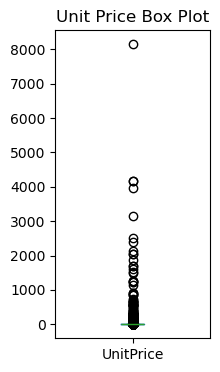

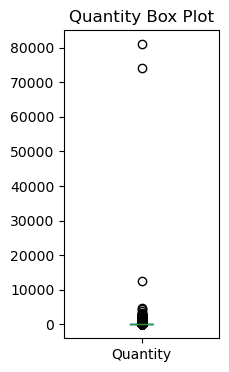

In [14]:
# Box plot for Unit Price
plt.figure(figsize=(2, 4)) 
df['UnitPrice'].plot(kind='box')
plt.title('Unit Price Box Plot')
plt.show()

# Box plot for Quantity
plt.figure(figsize=(2, 4))
df['Quantity'].plot(kind='box')
plt.title('Quantity Box Plot')
plt.show()

From the box plots above, we can see that most unit prices are below $1,000, with some data between $1,000 and $2,000, and 4 observations exceeding $3,000.

For quantity, most data are concentrated under 10,000 units. There are three orders that are extremely large, exceeding 10,000 units.

Both Unit Price and Quantity are positively (right) skewed; however, Quantity shows a more pronounced right skew. Both variables have extreme outliers.

### Create useful data
Monetary Value = Quantity * UnitPrice

Monetary value can be consider as the money that expect to receive from selling something. 

In [15]:
# Create new columns monetary value. 
df['MonetaryValue'] = df['Quantity'] * df['UnitPrice']

## Explore Data
1. Top 10 selling products and their sales share: *Description × Monetary Value*.

2. Top 10 products generating the most quantity (most popular): *Description × Quantity*.

3. Top 10 customers with the highest spending.

4. Number of customers who purchased only once: *InvoiceDate × CustomerID*

    → There are a total of 1,556 customers who purchased only once, which is 35.86% of all customers.

5. Top 10 customers with the longest time span of purchases: *InvoiceDate × CustomerID*.

6. Detect seasonality or demand spikes: *InvoiceDate × InvoiceNo*

    → We recognize that the dataset spans only one year, making it difficult to detect clear seasonality. However, from the available data, early to mid-November shows the most transactions.

7. Total sales per month: *InvoiceDate × Monetary Value*

    → Calculating total sales per month reinforces that November is the key month, with the most transactions and highest sales. Total sales started increasing from September and peaked in November.

8. Find peak shopping hours: *InvoiceDate × InvoiceNo*

    → Peak hours are around noon. As the time moves away from 12 PM, transaction counts decrease.

9. Sales by region: *Monetary Value × Country*

    → Most orders are placed by customers from the United Kingdom.

10. Customers by region: *CustomerID × Country*

    → About 92.6% of customers are from the United Kingdom, followed by Germany, France, and Spain.

In [16]:
# Find top 10 selling products and their sales share
# Create a table that has products' total sales
top_selling = df.groupby('Description')['MonetaryValue'].sum().sort_values(ascending=False).head(10)
top_selling_df = top_selling.reset_index()
top_selling_df.rename(columns={'MonetaryValue': 'TotalSales'}, inplace=True)

total_sales = df['MonetaryValue'].sum()

# Compute Sales Share: products' total sales/all products total sales
top_selling_df['SalesShare'] = top_selling_df['TotalSales'] / total_sales * 100
top_selling_df

,Description,TotalSales,SalesShare
0,"PAPER CRAFT , LITTLE BIRDIE",168469.60,1.890494
1,REGENCY CAKESTAND 3 TIER,142592.95,1.600117
2,WHITE HANGING HEART T-LIGHT HOLDER,100448.15,1.127186
3,JUMBO BAG RED RETROSPOT,85220.78,0.956311
4,MEDIUM CERAMIC TOP STORAGE JAR,81416.73,0.913624
5,POSTAGE,77803.96,0.873083
6,PARTY BUNTING,68844.33,0.772542
7,ASSORTED COLOUR BIRD ORNAMENT,56580.34,0.634920
8,Manual,53779.93,0.603495
9,RABBIT NIGHT LIGHT,51346.20,0.576185


In [17]:
# Find the product generate the most quantity
top_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_quantity_df = top_quantity.reset_index()
top_quantity_df

,Description,Quantity
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,77916
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
3,JUMBO BAG RED RETROSPOT,46181
4,WHITE HANGING HEART T-LIGHT HOLDER,36725
5,ASSORTED COLOUR BIRD ORNAMENT,35362
6,PACK OF 72 RETROSPOT CAKE CASES,33693
7,POPCORN HOLDER,30931
8,RABBIT NIGHT LIGHT,27202
9,MINI PAINT SET VINTAGE,26076


In [18]:
# Top 10 Customers with most spending
top_selling_customer = df.groupby('CustomerID')['MonetaryValue'].sum().sort_values(ascending=False).head(10)
top_selling_customer_df = top_selling_customer.reset_index()
top_selling_customer_df

,CustomerID,MonetaryValue
0,14646,280206.02
1,18102,259657.30
2,17450,194550.79
3,16446,168472.50
4,14911,143825.06
5,12415,124914.53
6,14156,117379.63
7,17511,91062.38
8,16029,81024.84
9,12346,77183.60


In [19]:
# Identify the time span of the dataset
start_date = df['InvoiceDate'].min()
end_date = df['InvoiceDate'].max()
time_span = end_date - start_date

print(f"Dataset covers from {start_date} to {end_date} ({time_span.days} days).")

Dataset covers from 2010-12-01 08:26:00 to 2011-12-09 12:50:00 (373 days).


Number of customer that only purchased once: 1556
Percentage of customer that only purchased once: 35.86079741876008


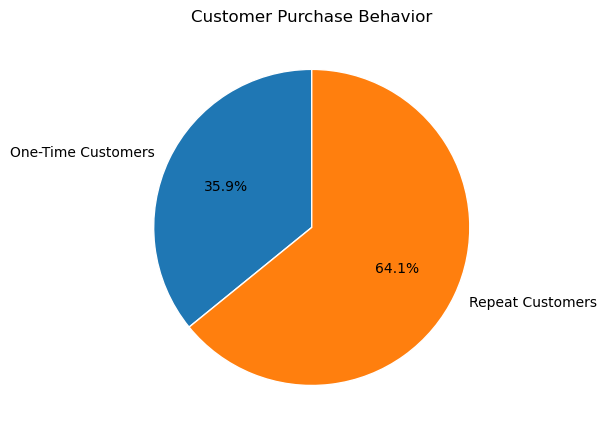

In [20]:
# Customer that only purchased once = time_span == 0
customer_span = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_span['time_span'] = customer_span['max'] - customer_span['min']

zero_span_customers = customer_span[customer_span['time_span'].dt.days == 0]
print(f'Number of customer that only purchased once: {len(zero_span_customers)}')
print(f'Percentage of customer that only purchased once: {(len(zero_span_customers)/df['CustomerID'].nunique())*100}')

one_time_count = len(zero_span_customers)
multi_time_count = df['CustomerID'].nunique() - one_time_count

labels = ['One-Time Customers', 'Repeat Customers']
sizes = [one_time_count, multi_time_count]

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Customer Purchase Behavior')
plt.tight_layout()
plt.show()


In [21]:
# Top 10 customers with longest time spam
top10_timespam = customer_span['time_span'].sort_values(ascending=False).head(10)
top10_timespam

CustomerID
15311   373 days 02:19:00
12748   372 days 23:32:00
12662   372 days 22:55:00
12433   372 days 20:38:00
13777   372 days 20:24:00
14606   372 days 02:31:00
15694   372 days 01:55:00
14911   372 days 01:49:00
16210   372 days 00:09:00
13408   371 days 22:26:00
Name: time_span, dtype: timedelta64[ns]

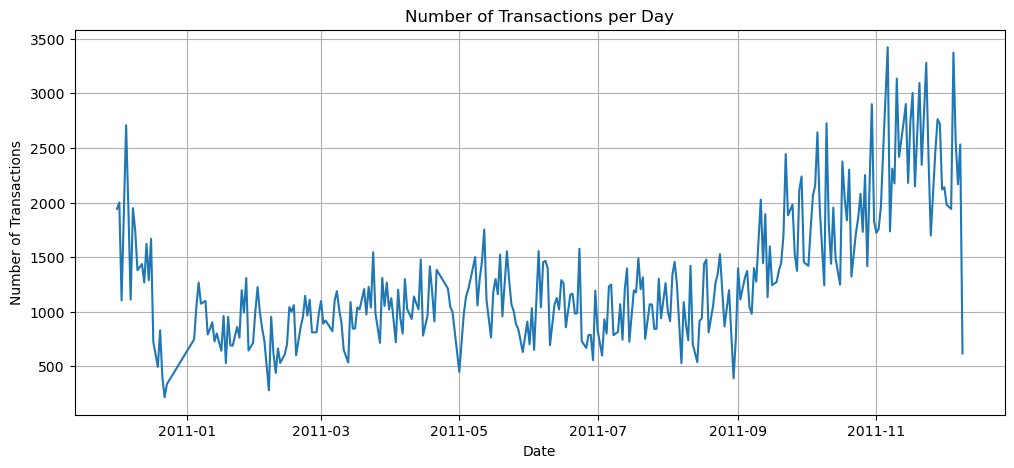

In [22]:
# Detect seasonality or demand spikes
transactions_per_day = df.groupby(df['InvoiceDate'].dt.date).size()

plt.figure(figsize=(12, 5))
plt.plot(transactions_per_day.index, transactions_per_day.values)
plt.title('Number of Transactions per Day')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

The best month was 2011-11 with total sales of 37,227,180,115.00


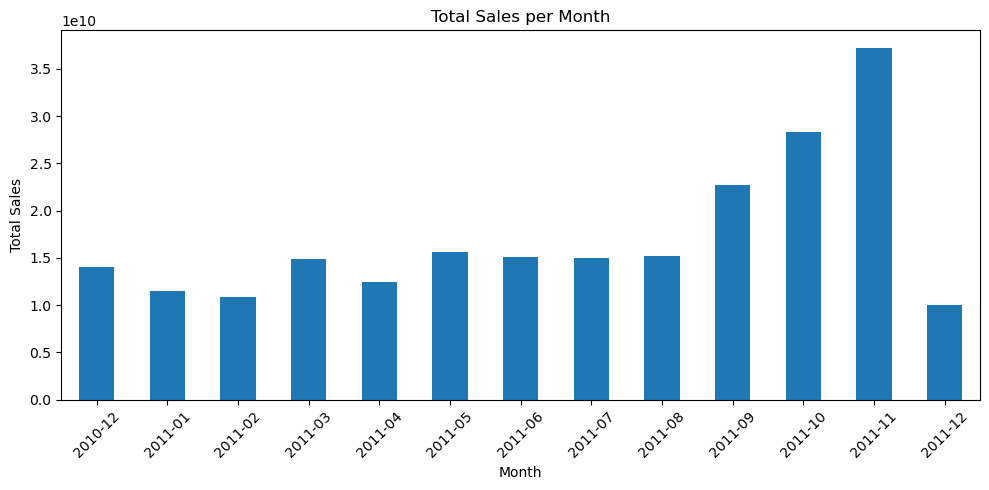

In [23]:
# Total Sales per Month
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

monthly_sales = df.groupby('YearMonth')['InvoiceNo'].sum()
best_month = monthly_sales.idxmax()
best_value = monthly_sales.max()

print(f"The best month was {best_month} with total sales of {best_value:,.2f}")

monthly_sales.plot(kind='bar', figsize=(10,5))
plt.title('Total Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The peak shopping hour is 12:00 with 3,130 invoices.


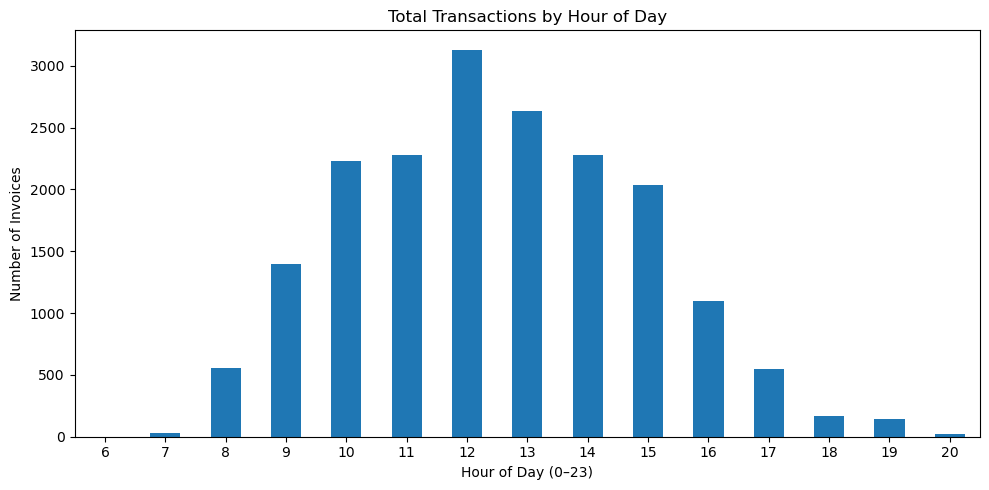

In [24]:
# Find peak shopping hours
df['Hour'] = df['InvoiceDate'].dt.hour

hourly_sales = df.groupby('Hour')['InvoiceNo'].nunique()

# Find peak hour
best_hour = hourly_sales.idxmax()
best_value = hourly_sales.max()

print(f"The peak shopping hour is {best_hour}:00 with {best_value:,} invoices.")

plt.figure(figsize=(10,5))
hourly_sales.plot(kind='bar')
plt.title('Total Transactions by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Invoices')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

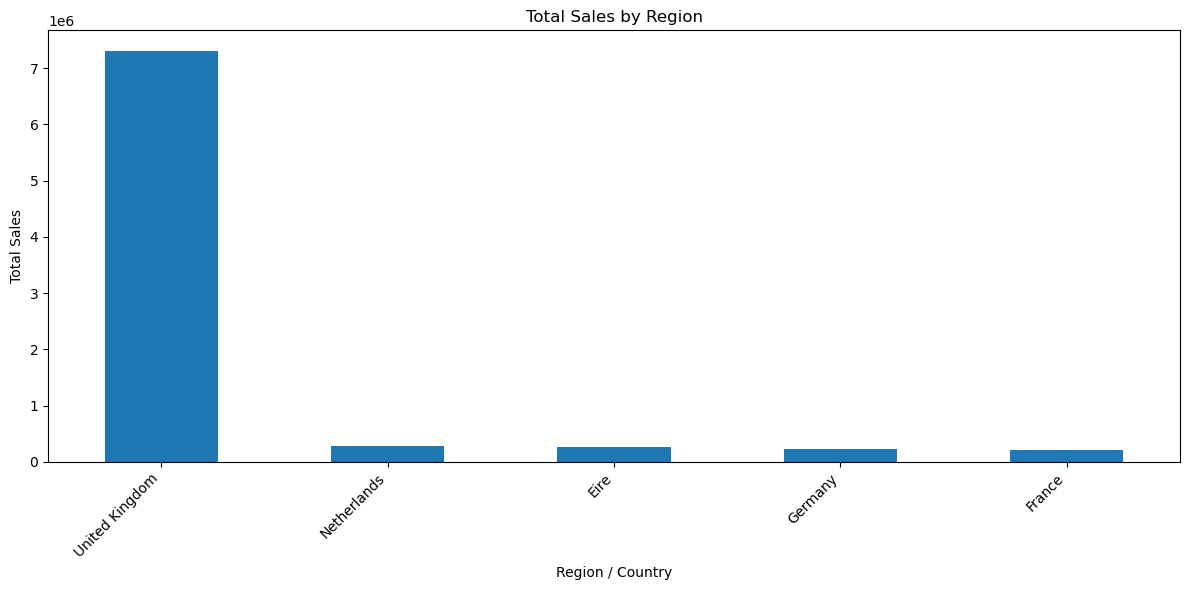

In [25]:
# Sales by region
region_sales = df.groupby('Country')['MonetaryValue'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(12,6))
region_sales.head(10).plot(kind='bar')
plt.title('Total Sales by Region')
plt.xlabel('Region / Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

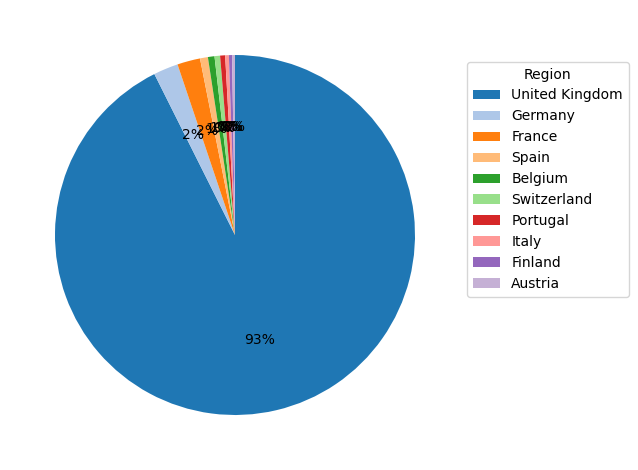

In [26]:
# Customer by region
region_customers = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)
top_regions = region_customers
regcolors = plt.cm.tab20.colors

plt.pie(
    region_customers.head(10),
    labels=None,
    autopct='%1.0f%%',
    startangle=90,
    counterclock=False,
    colors=regcolors
)

plt.legend(region_customers.head(10).index, title="Region", bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

## RFM Analysis
RFM stands for Recency, Frequency, and Monetary Value — a marketing analysis framework used for customer segmentation and behavioral targeting. It helps businesses identify their most valuable customers based on purchasing behavior, enabling data-driven decisions to improve strategy and performance.

Recency: How recently a customer made their last purchase.

Frequency: How often a customer makes purchases.

Monetary Value: How much a customer spends.

The main objective of RFM analysis is to identify high-value customers and understand purchasing patterns. By leveraging these insights, businesses can optimize marketing strategies, improve product positioning, and increase revenue through better customer engagement.



In [27]:
# Create RFM Table
refrence_date = df['InvoiceDate'].max() + pd.Timedelta(days = 1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (refrence_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'MonetaryValue': 'sum'                                    # Monetary
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Sales': 'Monetary'
}, inplace=True)

rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,278,1,180.60
18281,181,1,80.82
18282,8,2,178.05


### Check RFM data and its distribution
An initial check of the RFM data is crucial, as it can significantly affect the clustering results. It’s important to understand that RFM variables are typically highly skewed.

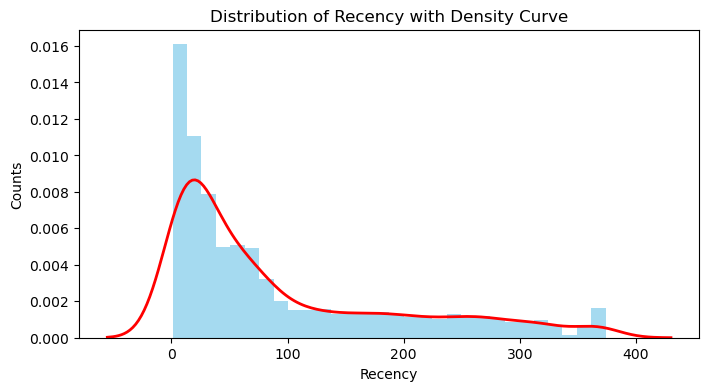

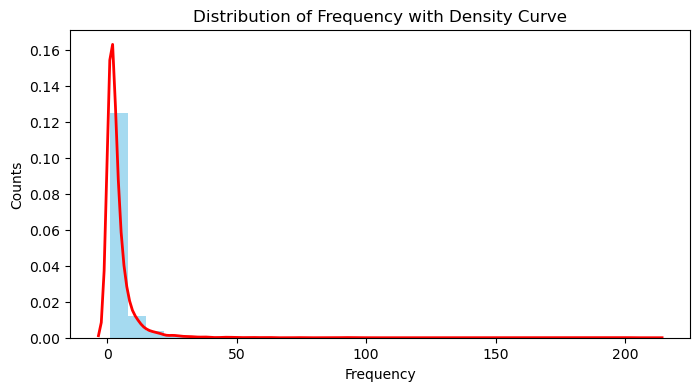

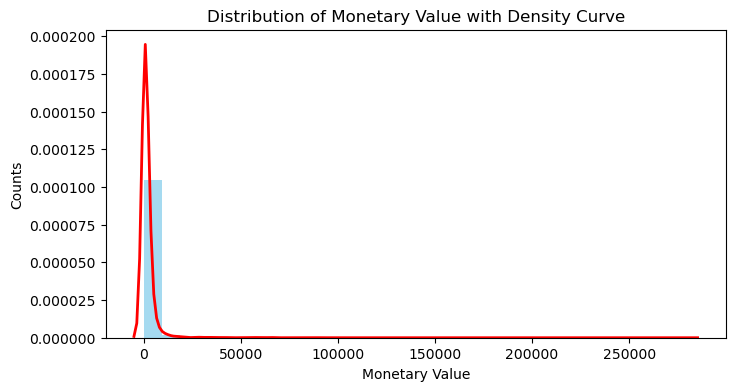

In [28]:
# Check distribution of Recency, Frequency, Monetary Value
# Plot Distribution of Recency
plt.figure(figsize=(8,4))
sns.histplot(rfm['Recency'], bins=30, color='skyblue', edgecolor=None, stat='density')
sns.kdeplot(rfm['Recency'], color='red', linewidth=2)
plt.title('Distribution of Recency with Density Curve')
plt.xlabel('Recency')
plt.ylabel('Counts')
plt.show()

# Plot Distribution of Frequency
plt.figure(figsize=(8,4))
sns.histplot(rfm['Frequency'], bins=30, color='skyblue', edgecolor=None, stat='density')
sns.kdeplot(rfm['Frequency'], color='red', linewidth=2)
plt.title('Distribution of Frequency with Density Curve')
plt.xlabel('Frequency')
plt.ylabel('Counts')
plt.show()

# Plot Distribution of Monetary 
plt.figure(figsize=(8,4))
sns.histplot(rfm['MonetaryValue'], bins=30, color='skyblue', edgecolor=None, stat='density')
sns.kdeplot(rfm['MonetaryValue'], color='red', linewidth=2)
plt.title('Distribution of Monetary Value with Density Curve')
plt.xlabel('Monetary Value')
plt.ylabel('Counts')
plt.show()

## RFM analysis

### Label RFM Score 
Labeling RFM scores might not be crucial for K-means clustering; however, it still provides better insight into customer placement and makes it easier for marketing or CRM teams to understand the segments.

In [29]:
# Label RFM Score
# Recency: lower value = better, so invert labels
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])

# Frequency: higher value = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])

# Monetary: higher value = better
rfm['M_Score'] = pd.qcut(rfm['MonetaryValue'], 4, labels=[1,2,3,4])


## K-Mean Clustering

Understanding the K-Means:

The objectives of K-Means clustering is to group similar data point, in our senarios, which is grouping customer into different segmens. It aim to minimize the inertia which is the distance between each data points to the centroids, which is what within cluster distance (using the Euclidean distance). tight kuit clusers showing a higher cohesiveness of the group. Then K-Means try to maximizing between clusters, which means each cluster can be more distinct. 

key concepts:

Inertia -- how far the points within a cluster are. 
--> lower the inertia is, better the K-Mean clustering. 

Dunn Index -- how far between clusters.
--> higher the Dunn Index, Better the K-Mean clustering is. 



### Data Preprocessing

Data Preprocessing is crucial for K-Mean Clustering as the raw data usually highly skewed and containing outliers. K-Means clustering works by minimizing the sum of squared distances between data points and cluster centroids. As K-Means uses Euclidean distance, it is sensitive to large values, which the outliers. 

We are going to applied Log Transformation and Z-score normalization to standardize our datasets. 

Log Transformation:
- It reduce skewness and compress large values while keeping the order of magnitude. Reducing the impact of extreme values and helps clusters form based on relative differences, improving the quality of the clustering. 

Z-score Normalization:
- It scale features to have mean = 0 and standard deviation =1, so all features contribute equally to clustering. The formula is z=(x-mu)/sigma. Z-score normalization ensures all features are on teh same scale. 

In [30]:
# Nomalize the data using log Transformation and z-score normalization
rfm_copy = rfm.copy()

rfm_copy['recency_log'] = np.log(rfm_copy['Recency'] + 1)
rfm_copy['frequency_log'] = np.log(rfm_copy['Frequency'] + 1)
rfm_copy['monetary_log'] = np.log(rfm_copy['MonetaryValue'] + 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_copy[['recency_log', 'frequency_log', 'monetary_log']])

rfm_norm = pd.DataFrame(X_scaled, columns=['Recency_Norm','Frequency_Norm','Monetary_Norm'])
rfm_norm

,Recency_Norm,Frequency_Norm,Monetary_Norm
0,1.462236,-0.955013,3.696168
1,-2.038611,1.074523,1.408758
2,0.373310,0.386437,0.715517
3,-0.622914,-0.955013,0.697821
4,1.424800,-0.955013,-0.615877
...,...,...,...
4334,1.343773,-0.955013,-1.102307
4335,1.024977,-0.955013,-1.734438
4336,-1.218789,-0.361412,-1.113519
4337,-1.657416,2.178046,0.836954


                Recency_Norm  Frequency_Norm  Monetary_Norm
Recency_Norm        1.000000       -0.569796      -0.482442
Frequency_Norm     -0.569796        1.000000       0.806681
Monetary_Norm      -0.482442        0.806681       1.000000


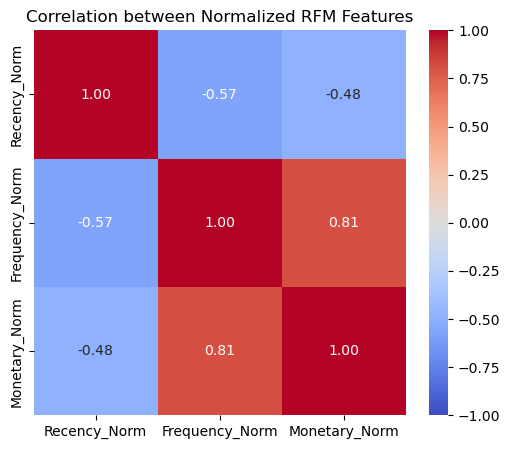

In [31]:
# Explore the Correlation of RFM Features
corr_matrix = rfm_norm.corr()
print(corr_matrix)

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_matrix,
    annot=True, 
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1
)
plt.title('Correlation between Normalized RFM Features')
plt.show()

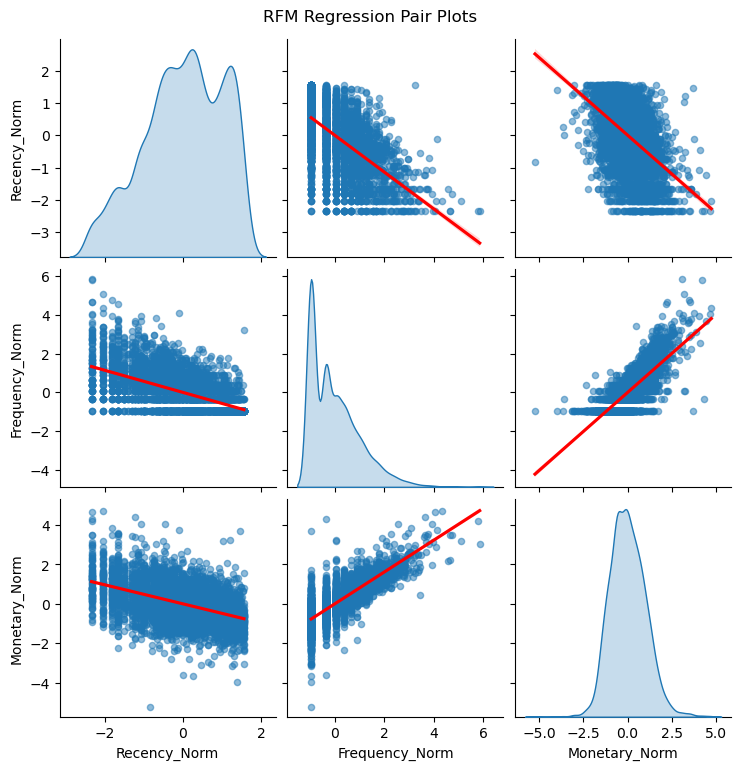

In [32]:
# Plot the RFM features
sns.pairplot(
    rfm_norm,
    kind='reg',
    diag_kind='kde',
    plot_kws={'scatter_kws': {'alpha':0.5, 's':20}, 'line_kws': {'color':'red'}}
)
plt.suptitle('RFM Regression Pair Plots', y=1.02)
plt.show()


From the heatmaps and pairplot we generated, we observe a strong positive relationship between Monetary Value and Frequency (correlation = 0.81), indicating that customers who purchase more frequently tend to contribute higher sales. 

Additionally, there is a moderate negative relationship between Recency and Frequency (correlation = -0.57), as well as between Recency and Monetary Value (correlation = -0.48). This suggests that the longer the time since a customer’s last purchase, the less frequently they make purchases, and the lower the total amount they spend.

## Elbow Method
Elbow method is widely used technique in clustering (especially K-Means) to help determine the optimal number of clusters (k). 

It run K-Means for a range of K values, and for each K, it calculate the Within_Cluster Sum of Squares (WCSS), aka inertia. 

Usually as k increases, WCSS always decreases as more clusters means smaller distances to centroids. 

Optimal number of cluster is the one that balancing cluster compactness and simplicity. Where the WCSS curve starts to flatten. 


Optimal number of clusters (Elbow Method): 5


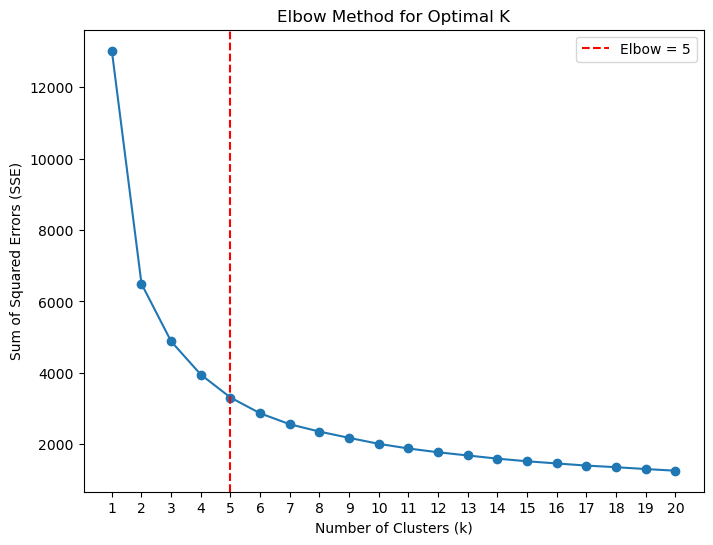

In [33]:
# Compute SSE (inertia) for different K
sse = []  # Sum of squared errors
kmeans_kwargs = {
    "init": "k-means++", 
    "n_init": 10,
    "max_iter": 300,
    "random_state": 127,
}
K_range = range(1, 21) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Apply KneeLocator to find the optimal k
kl = KneeLocator(K_range, sse, curve="convex", direction="decreasing")

print(f"Optimal number of clusters (Elbow Method): {kl.elbow}")

plt.figure(figsize=(8, 6))
plt.plot(K_range, sse, marker='o')
plt.xticks(K_range)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal K")
plt.axvline(x=kl.elbow, color='red', linestyle='--', label=f'Elbow = {kl.elbow}')
plt.legend()
plt.show()

In [34]:
optimal_k = kl.elbow
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(X_scaled)
rfm['K_Cluster_elbow'] = kmeans.labels_
rfm


,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,K_Cluster_elbow
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,4,1
12347,2,7,4310.00,4,4,4,2
12348,75,4,1797.24,2,3,4,1
12349,19,1,1757.55,3,1,4,0
12350,310,1,334.40,1,1,2,4
...,...,...,...,...,...,...,...
18280,278,1,180.60,1,2,1,4
18281,181,1,80.82,1,2,1,4
18282,8,2,178.05,4,3,1,0


### Visualization

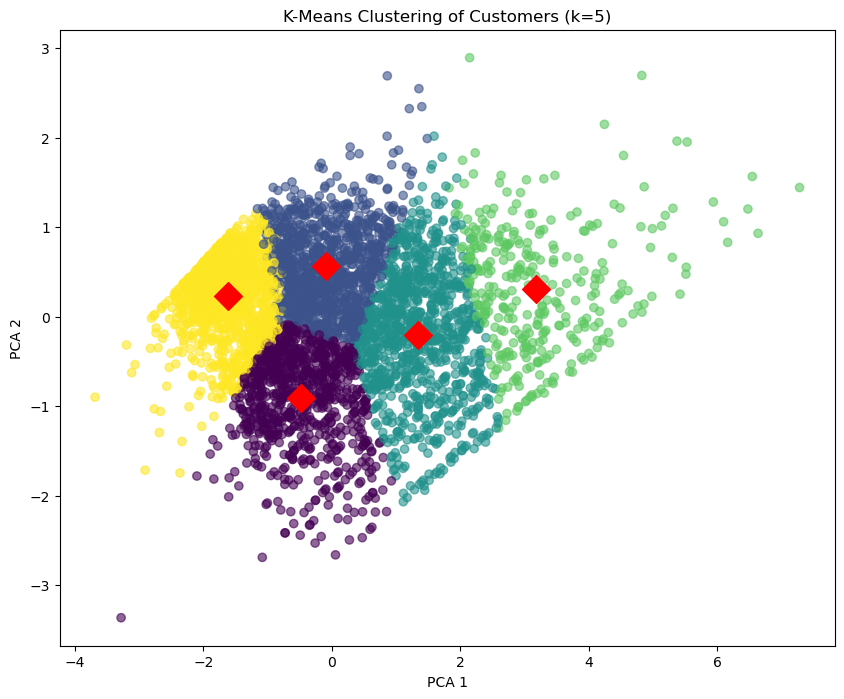

In [35]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Assign PCA columns
pca_x = X_pca[:, 0]
pca_y = X_pca[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(pca_x, pca_y, c=rfm['K_Cluster_elbow'], cmap='viridis', alpha=0.6)

centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
centroids_x = centroids_pca[:, 0]
centroids_y = centroids_pca[:, 1]

plt.scatter(centroids_x, centroids_y, marker='D', s=200, c='red')

plt.title(f'K-Means Clustering of Customers (k={optimal_k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

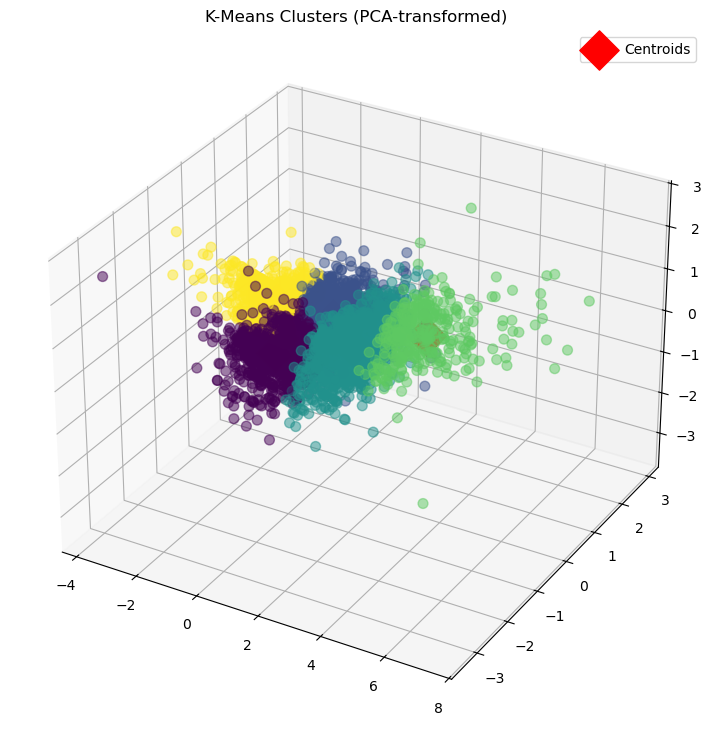

In [36]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(kmeans.cluster_centers_)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
           c=rfm['K_Cluster_elbow'], cmap='viridis', s=50, alpha=0.5)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
           c='red', s=400, marker='D', label='Centroids', depthshade=False)
ax.set_title('K-Means Clusters (PCA-transformed)')
ax.legend()
plt.show()


## Silhouette Method
Silhouette method is another method to evaliate clustering quality and help to fin dthe optimal number of clusters(k). 

It is measureing how similar a data point is to its own cluster compared to other cluster. 

Silhouette Score Evaluation and range:

0.71-1: Strong structure and clusters well-seperated;

0.51-0.7: Reasonable structure;

0.26-0.5: Weak structure, overlapping clusters

< 0.25: No substantial structure

Usually higher silhouette Score means the data is well separated. 

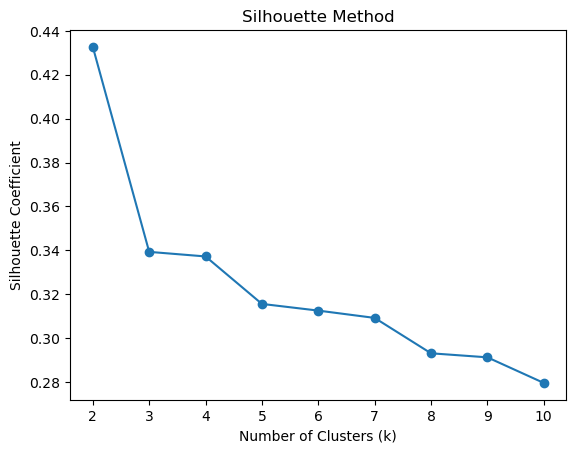

In [37]:
# Silhouette Method
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Method")
plt.show()

In [38]:
features = rfm_norm[['Recency_Norm', 'Frequency_Norm', 'Monetary_Norm']].copy()

for k in [2,3,4,5,6,7]:
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",  
        n_init=20,        
        max_iter=300,
        random_state=42  
    )
    labels = kmeans.fit_predict(rfm_norm)
    score = silhouette_score(rfm_norm, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")

K=2, Silhouette Score=0.433
K=3, Silhouette Score=0.336
K=4, Silhouette Score=0.336
K=5, Silhouette Score=0.316
K=6, Silhouette Score=0.313
K=7, Silhouette Score=0.309


In [39]:
kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
rfm['K_Cluster_silhouette'] = kmeans.fit_predict(X_scaled)

rfm['K_Cluster_silhouette'] = kmeans.labels_
rfm.groupby('K_Cluster_silhouette')[['Recency', 'Frequency', 'MonetaryValue']].mean().round(2)

,Recency,Frequency,MonetaryValue
K_Cluster_silhouette,,,
0,134.09,1.67,497.55
1,25.88,8.44,4548.26


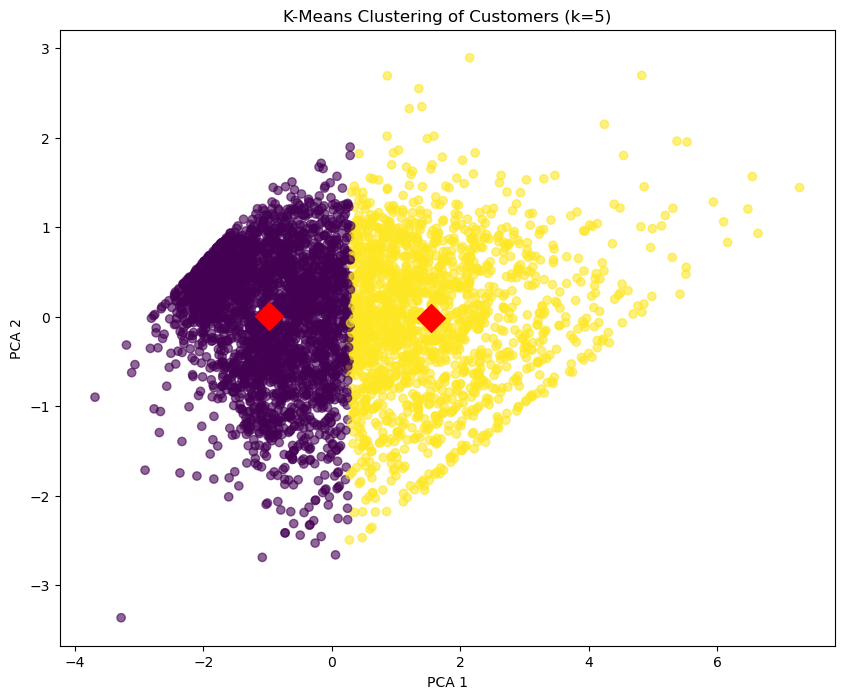

In [40]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_x = X_pca[:, 0]
pca_y = X_pca[:, 1]

# Scatter plot of customers, colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(pca_x, pca_y, c=rfm['K_Cluster_silhouette'], cmap='viridis', alpha=0.6)

centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
centroids_x = centroids_pca[:, 0]
centroids_y = centroids_pca[:, 1]

plt.scatter(centroids_x, centroids_y, marker='D', s=200, c='red')

plt.title(f'K-Means Clustering of Customers (k={optimal_k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

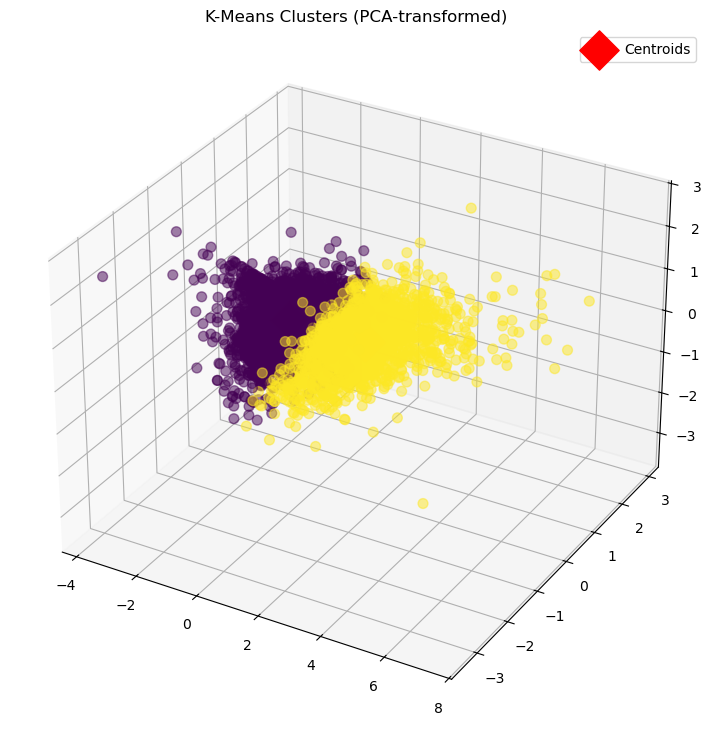

In [41]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(kmeans.cluster_centers_)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
           c=rfm['K_Cluster_silhouette'], cmap='viridis', s=50, alpha=0.5)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
           c='red', s=400, marker='D', label='Centroids', depthshade=False)
ax.set_title('K-Means Clusters (PCA-transformed)')
ax.legend()
plt.show()


## Profilling and Labeling

### Labeling the Cluster Groups

In [42]:
# Check Data of K_Cluster elbow method
K_Cluster_elbow_info = rfm.groupby('K_Cluster_elbow')[['Recency', 'Frequency', 'MonetaryValue']].mean().round(2)
K_Cluster_elbow_info

,Recency,Frequency,MonetaryValue
K_Cluster_elbow,,,
0,26.91,1.64,392.14
1,107.41,3.06,1422.10
2,19.32,5.78,2183.03
3,12.01,20.64,13751.80
4,208.75,1.20,270.92


In [43]:
# Based on information above, identify the labels
cluster_labels_elbow = {
    0: 'New or Occasional Buyers',
    1: 'Potential Loyalists',
    2: 'Loyal Customers',
    3: 'VIP / Champions',
    4: 'Lost Customers'
}

# Create a column for the elbow method labeling
rfm['Cluster_Label_elbow'] = rfm['K_Cluster_elbow'].map(cluster_labels_elbow)


In [44]:
# Check K_Cluster Silhouette method data
K_Cluster_silhouette_info = rfm.groupby('K_Cluster_silhouette')[['Recency', 'Frequency', 'MonetaryValue']].mean().round(2)
K_Cluster_silhouette_info

,Recency,Frequency,MonetaryValue
K_Cluster_silhouette,,,
0,134.09,1.67,497.55
1,25.88,8.44,4548.26


In [45]:
# Based on information above, identify the labels
cluster_labels_silhouette = {
    0: 'Low-value customers',
    1: 'High-value customers',
}

# Create a column for the silhouette method labeling
rfm['Cluster_Label_silhouette'] = rfm['K_Cluster_silhouette'].map(cluster_labels_silhouette)


## Business Insights from K-mean Clustering Results

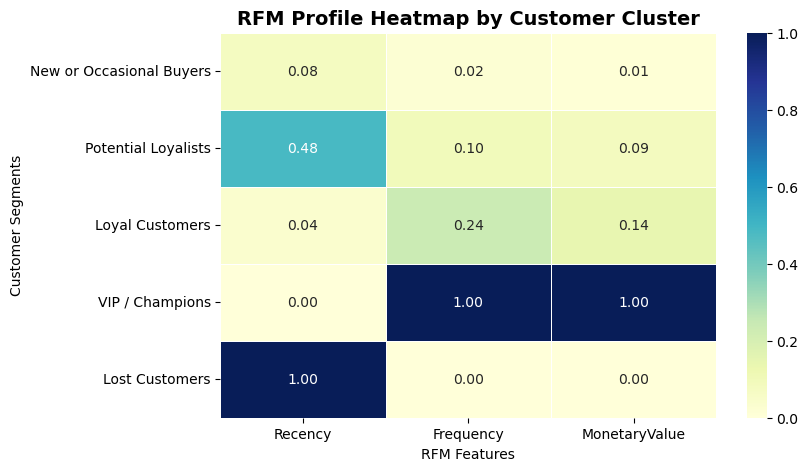

In [46]:
rfm_cluster_summary = rfm.groupby('K_Cluster_elbow')[['Recency', 'Frequency', 'MonetaryValue']].mean()
rfm_cluster_summary.rename(index=cluster_labels_elbow, inplace=True)

rfm_cluster_norm = (rfm_cluster_summary - rfm_cluster_summary.min()) / (rfm_cluster_summary.max() - rfm_cluster_summary.min())

plt.figure(figsize=(8, 5))
sns.heatmap(
    rfm_cluster_norm,
    annot=True,
    cmap='YlGnBu',
    linewidths=0.5,
    fmt=".2f"
)
plt.title('RFM Profile Heatmap by Customer Cluster', fontsize=14, fontweight='bold')
plt.ylabel('Customer Segments')
plt.xlabel('RFM Features')
plt.show()

In [47]:
# Count customers per cluster
cluster_counts = rfm['Cluster_Label_elbow'].value_counts().sort_index()

# Total revenue per cluster
cluster_revenue = rfm.groupby('Cluster_Label_elbow')['MonetaryValue'].sum()

# Combine summary
summary_elbow = pd.DataFrame({
    'CustomerCount': cluster_counts,
    'TotalRevenue': cluster_revenue,
    'AvgRevenuePerCustomer': cluster_revenue / cluster_counts,
    'CustomerPct': (cluster_counts / len(rfm)) * 100,
    'RevenuePct': (cluster_revenue / rfm['MonetaryValue'].sum()) * 100
}).round(2)

print(K_Cluster_elbow_info)

summary_elbow

                 Recency  Frequency  MonetaryValue
K_Cluster_elbow                                   
0                  26.91       1.64         392.14
1                 107.41       3.06        1422.10
2                  19.32       5.78        2183.03
3                  12.01      20.64       13751.80
4                 208.75       1.20         270.92


,CustomerCount,TotalRevenue,AvgRevenuePerCustomer,CustomerPct,RevenuePct
Cluster_Label_elbow,,,,,
Lost Customers,1184,320773.13,270.92,27.29,3.60
Loyal Customers,963,2102255.21,2183.03,22.19,23.59
New or Occasional Buyers,833,326653.16,392.14,19.20,3.67
Potential Loyalists,1016,1444858.49,1422.10,23.42,16.21
VIP / Champions,343,4716867.91,13751.80,7.91,52.93


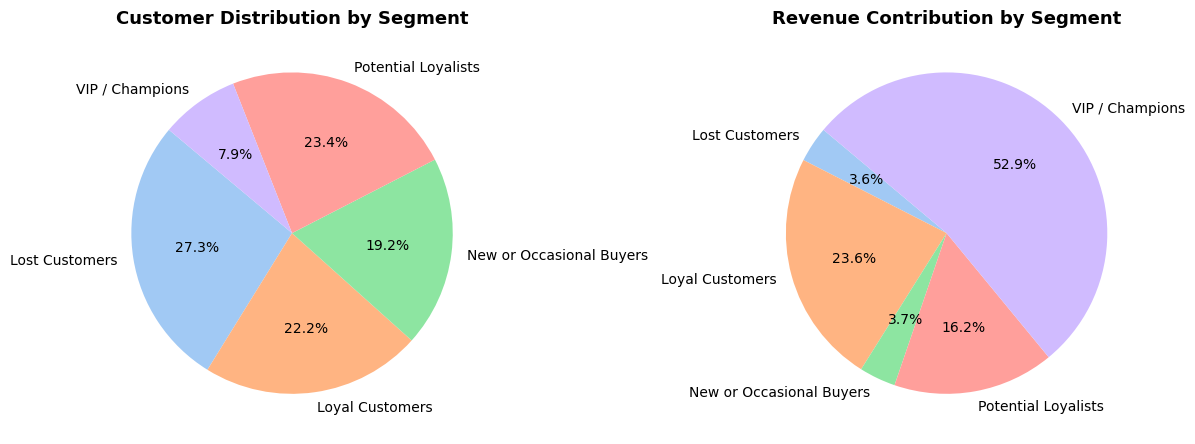

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Customer % pie chart
axes[0].pie(
    summary_elbow['CustomerPct'],
    labels=summary_elbow.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel"),
    textprops={'fontsize': 10}
)
axes[0].set_title('Customer Distribution by Segment', fontsize=13, fontweight='bold')

# Revenue % pie chart
axes[1].pie(
    summary_elbow['RevenuePct'],
    labels=summary_elbow.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel"),
    textprops={'fontsize': 10}
)
axes[1].set_title('Revenue Contribution by Segment', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


Based on the K-means clustering (5 clusters), we constructed the *K_Cluster_elbow_info* and *summary_elbow* dataframes, in which data was aggregated by cluster labels. The key findings are as follows:

**Cluster Mapping**: 

0: 'New or Occasional Buyers'

1: 'Potential Loyalists'

2: 'Loyal Customers'

3: 'VIP / Champions'

4: 'Lost Customers'


**Observations**: 
1. The *VIPs/Champions* make up 7.91% of the customer base; however, they generate 52.93% of the total revenue, driving the most revenue overall. This confirms the Pareto principle, where a small fraction of customers drive most of the revenue. Therefore, retaining or expanding the VIP/Champions group is critical. The recency of this group is 12 days, showing a clear evidence of engagement and ongoing activity. 

2. Around 45% of the customer base (*Loyal* and *Potential Loyalists*) is moderately engaged, generating nearly 40% of total revenue. This presents a healthy and scalable middle-tier customer segment. These groups represent the best opportunity to increase future revenue.The business would benefit from moving them toward the VIP tier. Providing a more personalized customer experience, including loyalty benefits or exclusive deals, would be a great way to do so.

3. For *Potential Loyalists*, the heatmaps indicating 0.48 for recency, showing that they haven't purchased very recently, which their activity level is moderate to declining. Even holding a slight higher frequency and monetary value than *New/Occasional Buyers* but most recent purchase was a while ago. Indicating they are at risk of becoming inactive. 
-  Since this group represents 22.2% of the customer base and contributes 16.2% of total revenue, they could be the key leverage point for improving overall retention and revenue growth.

4. Notice that *New or Occasional Buyers* and *Lost Customers* account for 19.2% and 27.29% of the customer base, respectively. They generate only 3.67% and 3.6% of the total revenue. The average purchase frequencies for these two groups are 1.64 and 1.2.
- The *New or Occasional Buyers* (19% of the customer base) show limited engagement.
- The *Lost Customers* form the largest cluster (27.29%) but contribute the lowest percentage of revenue (3.6%).
- Nearly half of the customers (46%) are inactive, showing weak retention. This presents the biggest churn risk, as the company is experiencing a high rate of attrition.
- This percentage suggests that while the company is able to attract customers and drive initial purchases, many customers leave after their first or second transaction.
- More attention should be given to product/service quality, potential competitive alternatives, and overall customer satisfaction.

**In summary**: 

The company is currently experiencing a customer base imbalance, where a small number of very loyal, high-spending customers generate the majority of revenue (7% of customers drive over half of total revenue), while a large portion of customers are disengaged (27% are *Lost*, 19% are *New or Occasional Buyers*). Nearly half (46%) of the customer base contributes less than 8% of total revenue, suggesting customer churn and weak retention. And there is exsiting risk where *potential loyalists* are potentially becoming inactive. 

The company is in a retention-heavy, revenue-concentrated phase, relying on a small group of VIPs for most of its sales while maintaining a large inactive customer base.

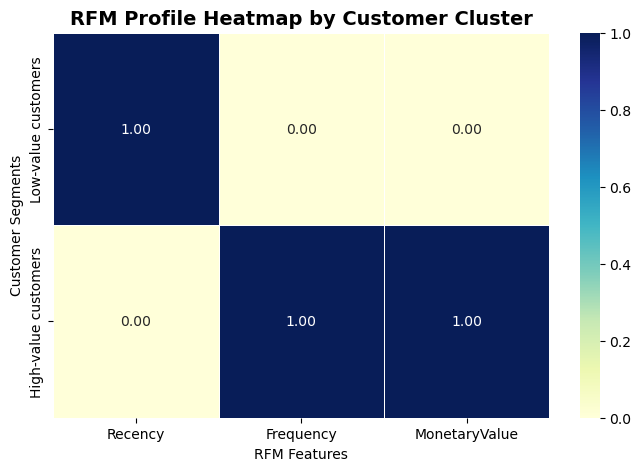

In [49]:
rfm_cluster_summary = rfm.groupby('K_Cluster_silhouette')[['Recency', 'Frequency', 'MonetaryValue']].mean()
rfm_cluster_summary.rename(index=cluster_labels_silhouette, inplace=True)

rfm_cluster_norm = (rfm_cluster_summary - rfm_cluster_summary.min()) / (rfm_cluster_summary.max() - rfm_cluster_summary.min())

plt.figure(figsize=(8, 5))
sns.heatmap(
    rfm_cluster_norm,
    annot=True,
    cmap='YlGnBu',
    linewidths=0.5,
    fmt=".2f"
)
plt.title('RFM Profile Heatmap by Customer Cluster', fontsize=14, fontweight='bold')
plt.ylabel('Customer Segments')
plt.xlabel('RFM Features')
plt.show()

In [50]:
# Count customers per cluster
cluster_counts = rfm['Cluster_Label_silhouette'].value_counts().sort_index()

# Total revenue per cluster
cluster_revenue = rfm.groupby('Cluster_Label_silhouette')['MonetaryValue'].sum()

# Combine summary
summary_silhouette = pd.DataFrame({
    'CustomerCount': cluster_counts,
    'TotalRevenue': cluster_revenue,
    'AvgRevenuePerCustomer': cluster_revenue / cluster_counts,
    'CustomerPct': (cluster_counts / len(rfm)) * 100,
    'RevenuePct': (cluster_revenue / rfm['MonetaryValue'].sum()) * 100
}).round(2)

print(K_Cluster_silhouette_info)
summary_silhouette

                      Recency  Frequency  MonetaryValue
K_Cluster_silhouette                                   
0                      134.09       1.67         497.55
1                       25.88       8.44        4548.26


,CustomerCount,TotalRevenue,AvgRevenuePerCustomer,CustomerPct,RevenuePct
Cluster_Label_silhouette,,,,,
High-value customers,1667,7581946.78,4548.26,38.42,85.08
Low-value customers,2672,1329461.12,497.55,61.58,14.92


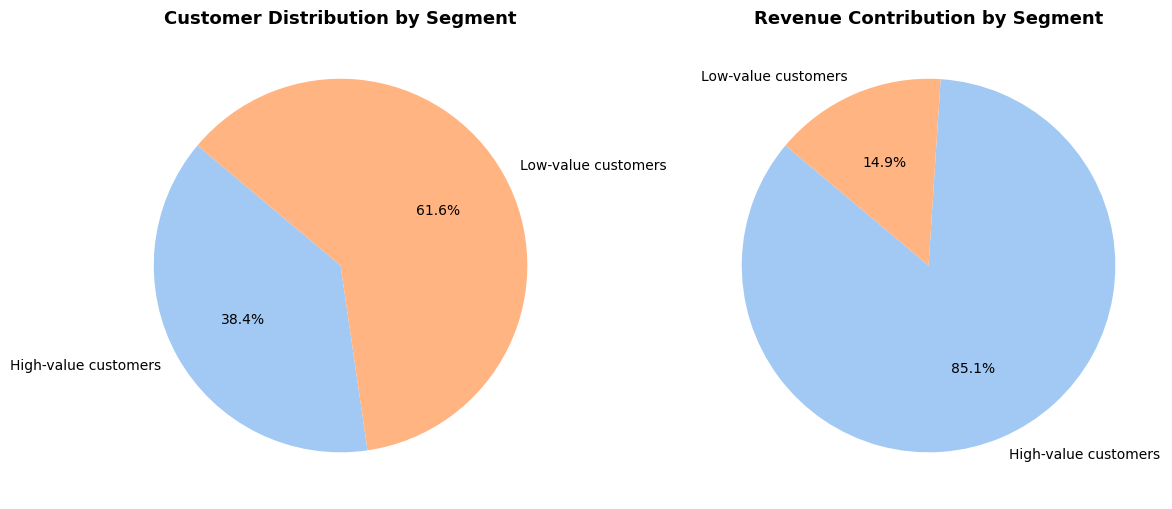

In [51]:
# --- Pie charts for Customer % and Revenue % ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Customer % pie chart
axes[0].pie(
    summary_silhouette['CustomerPct'],
    labels=summary_silhouette.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel"),
    textprops={'fontsize': 10}
)
axes[0].set_title('Customer Distribution by Segment', fontsize=13, fontweight='bold')

# Revenue % pie chart
axes[1].pie(
    summary_silhouette['RevenuePct'],
    labels=summary_silhouette.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel"),
    textprops={'fontsize': 10}
)
axes[1].set_title('Revenue Contribution by Segment', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

Based on the K-means clustering (5 clusters), we constructed the *K_Cluster_silhouette_info* and *summary_silhouette* dataframe dataframes, in which data was aggregated by cluster labels. The key findings are as follows:

**Cluster Mapping**: 

0: 'Low-value customers'

1: 'High-value customers'

**Observations**:
1. The *low-value customers*'s frequency is 1.67, which highlights that the customer leave after one or second transaction, reensure the low retention rate. 

2. The *low-value customers* take over 61.58% of the customer base but only showing 14.92% of the total revenue. And h*igh value customers* is hvaing 38.42% customer base and 85.08%. This shown a potential risk as we highly relying on specific customers to product revenue. Presenting a high customer concentration risk. 

3. *High-value customers* have a much lower recency (≈ 26 days) compared to *low-value customers* (≈ 134 days); and they purchase 8.44 times on average, compared to 1.67 times among *low-value customers*, which is roughly 5x more frequent. And the average spending (4548.26) is nearly 9x higher than *lower-value groups*(497.55). Showing that *high-value customers* are active, loyal, and profitable. 


## Business Recommendations
1. **Retain VIPs and High-Value Customers**
- Focus on customers who are active, loyal, and generate the most revenue. Offer loyalty rewards, early access, and personalized offers to further build relationships and trust.
- Understand their needs and satisfaction levels to develop more tailored offers. Learn from loyal customers to identify what drives their continued engagement.
- Consider implementing advocacy programs that encourage referrals or testimonials.
2. **Increase retention rate**
- Launch reactivation campaigns based on past customer preferences.
- Conduct an in-depth analysis of the customer experience to identify obstacles in the user journey, evaluate competitive alternatives, and assess customer service quality. Determine the key reasons why some customers do not make repeat purchases.
- Implement promotional campaigns through personalizaed engagment and early loyalty incentives.
- Set up automated campaigns triggered by customer inactivity.
